In [1]:
import argparse  # Commandline input

import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file  # or use curl

# To get info about the GW events
from pycbc.catalog import Catalog, Merger

# used for setting priors or initial points of walkers
from pycbc.distributions import JointDistribution, SinAngle, Uniform

# Signal processing and Matched filtering
from pycbc.filter import highpass, matched_filter, resample_to_delta_t, sigma
from pycbc.frame import read_frame  # read the GW data which is in gwf format

# likelihood and stochastic samplers
from pycbc.inference import models, sampler

# BaseModel is inherited and used to make manual models
from pycbc.inference.models.base import BaseModel

# PSD estimation
from pycbc.psd import interpolate, inverse_spectrum_truncation

# td referes to time domain, there is equivalently frequency domain (get_fd_waveform)
from pycbc.waveform import get_td_waveform, fd_approximants  # Generate GWaveforms
from pycbc import inference  # Used for IO in this file
from scipy.stats import norm
from IPython.display import Image  # Generate image of posterior
from IPython.display import HTML  # Generate summary of the posterior results
from scipy.integrate import quad
import scipy.stats as st
import h5py
import hashlib
import pandas as pd

plt.style.use("standard.mplstyle")


/home/ash/.local/lib/python3.10/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/ash/.local/lib/python3.10/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


# Analysis of Inference file 

In [2]:
posterior_samples_file = "GW190521_posterior_samples.h5"

samples_file = h5py.File(posterior_samples_file, "r")

seob = samples_file["SEOBNRv4PHM"]["posterior_samples"]
print(seob)
samples_dict = dict(SEOB=seob) # making a dictionary
print(samples_dict)

mass1 = samples_dict["SEOB"]["mass_1"]
mass2 = samples_dict["SEOB"]["mass_2"]
print("Mass1 ", mass1)
print("Mass2 ", mass2)
print("Mass 1 is always greater than Mass2 ", np.sum(mass2>mass1))
spin1z = samples_dict["SEOB"]["spin_1z"]
spin2z = samples_dict["SEOB"]["spin_2z"]
chieff = samples_dict["SEOB"]["chi_eff"]
q = samples_dict["SEOB"]["mass_ratio"] # assumed mass 1 is greater than mass2, therefore q = mass1/mass2
print("Q ",q)



<HDF5 dataset "posterior_samples": shape (19822,), type "|V408">
{'SEOB': <HDF5 dataset "posterior_samples": shape (19822,), type "|V408">}
Mass1  [383.6069  378.91714 378.61285 ... 117.0328  115.85609 115.31842]
Mass2  [ 55.275036  51.109505  53.758537 ... 115.80238  114.31724  110.79952 ]
Mass 1 is always greater than Mass2  0
Q  [0.14409291 0.13488306 0.14198815 ... 0.98948654 0.98671757 0.96081372]


In [3]:
# fp = inference.io.loadfile("inference_gw190521_IMRPhenom_chieff_q.hdf", "r")
# print(fp.keys())
# print(fp["samples"].keys())
# samples = fp.read_samples(fp["samples"], temps=0)
# print(samples)
# mass1 = samples["mass1"]
# spin1z = samples["spin1z"]
# q = samples["q"]
# chieff = samples["chi_eff"]
# loglikelihood = samples["loglikelihood"]
# print(np.max(loglikelihood))
# print(np.min(loglikelihood))
# print(np.max(loglikelihood) - 8)
# # https://ned.ipac.caltech.edu/level5/Wall2/Wal3_4.html
# # In our case DOF = 4 and 90% credible interval would be equivalent to around 8


# Entropies E1 and E2

In [4]:
E1 = (mass1**2) * (
    1 + np.sqrt(1 - np.abs(spin1z) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
# mass2 = mass1 / q
# spin2z = chieff * (1 + q) - q * spin1z
print("Limit of spin2z is ", np.min(spin2z), np.max(spin2z))
E2 = (mass2**2) * (1 + np.sqrt(1 - np.abs(spin2z) ** 2))  # Initial Entropy of BH2

E1 = E1.reshape(E1.shape[0], 1)
E2 = E2.reshape(E2.shape[0], 1)
print(E1.shape)


Limit of spin2z is  -0.9808005860774514 0.9749757550302984
(19822, 1)


# Merger Entropy Index

In [5]:
def brahmacolumns(rho, limit, Ef):
    # mode should be string 220 or 220_221
    """rho = Percentage of fail to be dropped off; limit = Theoretical limit, uniform prior, astrophysical prior"""
    if limit > 1:  # so that original samples remain same after applying np.delete to delete rows/columns
        # rows = [] # nothing will get deleted
        columns = []
        failcolumn = []
        return columns, failcolumn
    columns = np.array([])
    failcolumn =  np.array([])
    # if modes == "220":
    for j in range(Ef.shape[1]):     
        IBBH = (1 / 3) * (Ef[0, j] - E1 - E2) / (E1 + E2)  # columns
        for i in range(IBBH.shape[1]):
            if np.sum(IBBH[:, i] > limit) >= 1 or np.sum(IBBH[:, i] < 0) >= 1:
                fail = 100 * (np.sum(IBBH[:, i] > limit) + np.sum(IBBH[:, i] < 0)) / IBBH.shape[0]
                # print("Column number number ", i, " percentage of Fail values ", fail)
                if fail >= rho:
                    columns = np.append(columns, int(j))
                    failcolumn = np.append(failcolumn,fail)
                    # IBBH_new = np.delete(IBBH, i, axis=1)


                
    # print("Minimum value in IBBH is ", np.min(IBBH))
    # print("Maximum value in IBBH is ", np.max(IBBH))
    # print("Shape of IBBH is ", IBBH.shape)
    # print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
    # print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
    # print(
    #     "Percentage of IBBH to be removed ",
    #     ((np.sum(IBBH > limit) + np.sum(IBBH < 0)) / (IBBH.shape[0] * IBBH.shape[1])) * 100,
    # )

    columns = columns.astype(np.int64)  # represents columns numbers to be deleted
    # print("Column numbers ", columns)

    return columns, failcolumn


In [6]:
def brahmarows(rho, limit, Ef):
    # mode should be string 220 or 220_221
    """rho = Percentage of fail to be dropped off; limit = Theoretical limit, uniform prior, astrophysical prior"""
    if limit > 1:  # so that original samples remain same after applying np.delete to delete rows/columns
        # rows = [] # nothing will get deleted
        rows = []
        failrow = []
        return rows, failrow
    rows = np.array([])
    failrow = np.array([])
    # if modes == "220":
    for j in range(E1.shape[0]):     
        IBBH = (1 / 3) * (Ef - E1[j,0] - E2[j,0]) / (E1[j,0] + E2[j,0])  # columns
        for i in range(IBBH.shape[0]):
            if (np.sum(IBBH[i, :] > limit) >= 1 or np.sum(IBBH[i, :] < 0) >=1):
                fail = 100 * (np.sum(IBBH[i, :] > limit) + np.sum(IBBH[i, :] < 0)) / IBBH.shape[1]
                # print("Row number ", i, " percentage of Fail values ", fail)
                if fail >= rho:
                    rows = np.append(rows, int(j))
                    failrow = np.append(failrow,fail)


    rows = rows.astype(np.int64) # represents rows numbers to be deleted
    # print("Row numbers ", rows)


    return rows, failrow


# Inspiral

In [7]:
posterior_samples_file = "GW190521_posterior_samples.h5"

samples_file = h5py.File(posterior_samples_file, "r")
seob = samples_file["SEOBNRv4PHM"]["posterior_samples"]
samples_dict = dict(SEOB=seob)
n = np.array(
    [2, 1, 0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []

def plotinspiral(modes, failperc, Ef):
   # Removing rows which fail the BRAHMA ramework test
    # modes = ["220_221"]
    for limit in n:
        print("For n: ", limit)
        for mode in modes:
            print("For Ringdown mode ", mode)
            rows, fail = brahmarows(rho=failperc, limit=limit, Ef = Ef)  # row and columns numbers to be deleted
            table = list(zip(rows,fail))
            df = pd.DataFrame(data = table, columns = ["Row #", "Fail %"])
            print(df)
            
            # columns = brahmacolumns(rho=10, limit=limit, modes=mode)  # row and columns numbers to be deleted
            # if mode == "220":
            #     samples = fp220.read_samples(fp220["samples"].keys(), temps=0)

            # if mode == "220_221":
            #     samples = fp220221.read_samples(fp220221["samples"].keys(), temps=0)
            # print(rows)
            chi_eff = np.delete(samples_dict["SEOB"]["chi_eff"], rows, axis=0)
            q = np.delete(samples_dict["SEOB"]["mass_ratio"], rows, axis=0)



            # final_spin = np.delete(samples["final_spin"], columns, axis=0)
            # final_mass = np.delete(samples["final_mass"], columns, axis=0)
            # loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
            # x = final_mass
            # y = final_spin

            # Extract x and y
            x = q
            y = chi_eff

            if limit > 1:  #
                deltaX = (max(x) - min(x)) / 2
                deltaY = (max(y) - min(y)) / 2
                xmin = min(x) - deltaX
                xmax = max(x) + deltaX
                ymin = min(y) - deltaY
                ymax = max(y) + deltaY
                # print(ymin, ymax)
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

                fig = plt.figure(figsize=(8, 5))
                ax = fig.gca()
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            if values.shape[1] == 0:
                continue
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

            percentiles = np.array([90.0])
            percentiles = 100.0 - np.array(percentiles)
            percentiles.sort()

            draw = kernel.resample
            resamps = kernel(draw(int(100**2)))
            s = np.percentile(resamps, percentiles)

            ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

            cset = ax.contour(xx, yy, f, s, colors="k")
            if limit > 1 :  #
                plt.figure(figsize=(8, 5))
            text = ["SEOBNRv4PHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
            colors = ["k", "g", "r"]
            for j in range(len(cset.allsegs)):
                for ii, seg in enumerate(cset.allsegs[j]):
                    if ii == 0:
                        if limit > 1:
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "-",
                                lw = 0.5,
                                color=colors[np.where(n == limit)[0][0]],
                                label=text[np.where(n == limit)[0][0]] + "\n ringdown mode " + str(mode),
                            )
                        else:
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "--",
                                color=colors[np.where(n == limit)[0][0]],
                                label=text[np.where(n == limit)[0][0]],
                            )
                    else:
                        plt.plot(seg[:, 0], seg[:, 1], "--", color=colors[np.where(n == limit)[0][0]])  # ax.set_xlabel("q")



    ax.set_xlabel("q")
    ax.set_ylabel("$\chi_{eff}$")
    plt.title("Posterior plot for Inspiral phase ")
    plt.ylim(-0.5, 0.8)
    plt.xlim(0,1)
    plt.xlabel("q")
    plt.ylabel("$\chi_{eff}$")
    plt.legend(title='90$\%$ credible Interval')
    # plt.xlim(245,400)
    plt.axvline(0.72,linestyle = '--')
    plt.axhline(0.06,linestyle = '--')
    plt.savefig(f"Inspiral{modes}-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")



    # ax.set_xlabel("$M_f$")
    # ax.set_ylabel("$\chi_{f}$")
    # plt.title("Posterior plot for Ringdown phase")

    # plt.xlabel("$M_f$")
    # plt.ylabel("$\chi_{f}$")
    # plt.legend(title='90$\%$ credible Interval')
    # plt.xlim(245,400)
    # plt.axvline(254.31,linestyle = '--')
    # plt.axhline(0.72,linestyle = '--')
    # plt.savefig("Ringdown220-221-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")
    plt.show()


In [8]:
posterior_samples_file = "GW190521_posterior_samples.h5"

samples_file = h5py.File(posterior_samples_file, "r")
seob = samples_file["SEOBNRv4PHM"]["posterior_samples"]
samples_dict = dict(SEOB=seob)


n = np.array(
    [2, 1, 0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []
# Removing rows which fail the BRAHMA ramework test
# modes = ["220_221", "220"]
def plotringdown(modes, failperc, Ef):
    for limit in n:
        print("For n: ", limit)
        for mode in modes:
            print("For Ringdown mode ", mode)
            # rows = brahmarows(rho=10, limit=limit, modes=mode)  # row and columns numbers to be deleted
            columns, fail = brahmacolumns(rho=failperc, limit=limit, Ef = Ef)  # row and columns numbers to be deleted
            table = list(zip(columns,fail))
            df = pd.DataFrame(data = table, columns = ["column #", "Fail %"])
            print(df)


            final_spin = np.delete(samples_dict["SEOB"]["final_spin"], columns, axis=0)
            final_mass = np.delete(samples_dict["SEOB"]["final_mass"], columns, axis=0)

            x = final_mass
            y = final_spin

            # Extract x and y
            # x = q
            # y = chi_eff

            if limit > 1:  #
                deltaX = (max(x) - min(x)) / 2
                deltaY = (max(y) - min(y)) / 2
                xmin = min(x) - deltaX
                xmax = max(x) + deltaX
                ymin = min(y) - deltaY
                ymax = max(y) + deltaY
                print(ymin, ymax)
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

                fig = plt.figure(figsize=(8, 5))
                ax = fig.gca()
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            if values.shape[1] == 0:
                continue
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

            percentiles = np.array([10.0])
            percentiles = 100.0 - np.array(percentiles)
            percentiles.sort()

            draw = kernel.resample
            resamps = kernel(draw(int(100**2)))
            s = np.percentile(resamps, percentiles)

            ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

            cset = ax.contour(xx, yy, f, s, colors="k")
            if limit > 1:  #
                plt.figure(figsize=(8, 5))
            text = ["SEOBNRv4PHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
            colors = ["k", "g", "r"]
            for j in range(len(cset.allsegs)):
                for ii, seg in enumerate(cset.allsegs[j]):
                    if ii == 0:
                        if limit > 1:
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "-",
                                lw = 0.5,
                                color=colors[np.where(n == limit)[0][0]],
                                label=text[np.where(n == limit)[0][0]] + "\n ringdown mode " + str(mode),
                            )
                        else:
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "--",
                                color=colors[np.where(n == limit)[0][0]],
                                label=text[np.where(n == limit)[0][0]],
                            )
                    else:
                        plt.plot(seg[:, 0], seg[:, 1], "--", color=colors[np.where(n == limit)[0][0]])  # ax.set_xlabel("q")
    # ax.set_xlabel("q")
    # ax.set_ylabel("$\chi_{eff}$")
    # plt.title("Posterior plot for Inspiral phase ")
    # plt.ylim(-0.5, 0.8)
    # plt.xlim(0,1)
    # plt.xlabel("q")
    # plt.ylabel("$\chi_{eff}$")
    # plt.legend(title='90$\%$ credible Interval')
    # # plt.xlim(245,400)
    # plt.axvline(0.72,linestyle = '--')
    # plt.axhline(0.7,linestyle = '--')
    # plt.savefig("Inspiral220_221-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")



    ax.set_xlabel("$M_f$")
    ax.set_ylabel("$\chi_{f}$")
    plt.title("Posterior plot for Ringdown phase")

    plt.xlabel("$M_f$")
    plt.ylabel("$\chi_{f}$")
    plt.legend(title='90$\%$ credible Interval')
    # plt.xlim(245,400)
    plt.axvline(265,linestyle = '--')
    plt.axhline(0.74,linestyle = '--')
    plt.savefig(f"Ringdown{modes}-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# IO read of Ringdown
# Final Entropy

In [9]:
massf = samples_dict["SEOB"]["final_mass"]
spinf = samples_dict["SEOB"]["final_spin"]
Ef = (massf**2) * (1 + np.sqrt(1 - np.abs(spinf) ** 2))
Ef = Ef.reshape(1,Ef.shape[0])


For n:  2.0
For Ringdown mode  220
Empty DataFrame
Columns: [Row #, Fail %]
Index: []
For n:  1.0
For Ringdown mode  220
      Row #     Fail %
0         0  99.919282
1         1  99.924327
2         2  99.873878
3         3  99.767935
4         4  99.672082
...     ...        ...
2073   7925  12.546665
2074   8003  13.374029
2075   8018  11.093734
2076   8210  10.089799
2077   8498  10.548885

[2078 rows x 2 columns]
For n:  0.5
For Ringdown mode  220
      Row #     Fail %
0         0  99.919282
1         1  99.924327
2         2  99.873878
3         3  99.767935
4         4  99.672082
...     ...        ...
2536  19817  19.367370
2537  19818  57.188982
2538  19819  18.378569
2539  19820  23.362930
2540  19821  65.457572

[2541 rows x 2 columns]


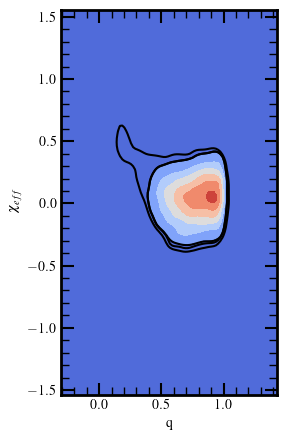

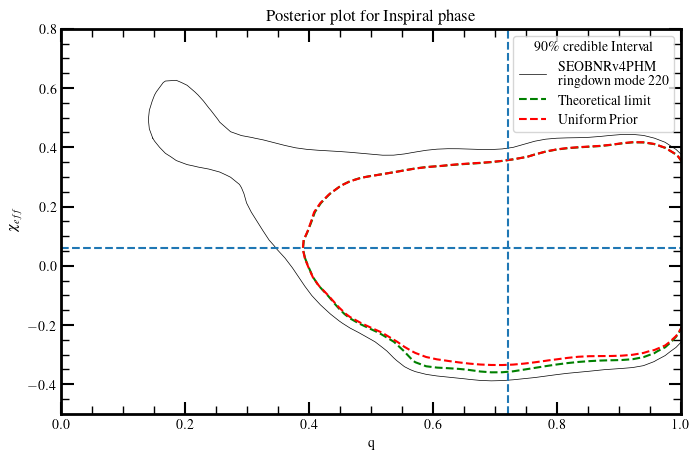

For n:  2.0
For Ringdown mode  220
Empty DataFrame
Columns: [column #, Fail %]
Index: []
-0.03441056380982205 1.3075032616507891
For n:  1.0
For Ringdown mode  220
      column #     Fail %
0            0  35.173040
1            1  36.716779
2            2  20.472203
3            3  27.242458
4            4  22.036121
...        ...        ...
2241     19817  26.581576
2242     19818  19.347190
2243     19819  24.523257
2244     19820  30.915145
2245     19821  31.767733

[2246 rows x 2 columns]
For n:  0.5
For Ringdown mode  220
      column #     Fail %
0            0  94.132782
1            1  94.208455
2            2  92.740389
3            3  93.507214
4            4  92.932096
...        ...        ...
3202     19817  26.581576
3203     19818  19.347190
3204     19819  24.523257
3205     19820  30.915145
3206     19821  31.767733

[3207 rows x 2 columns]


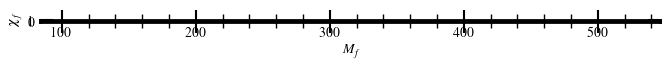

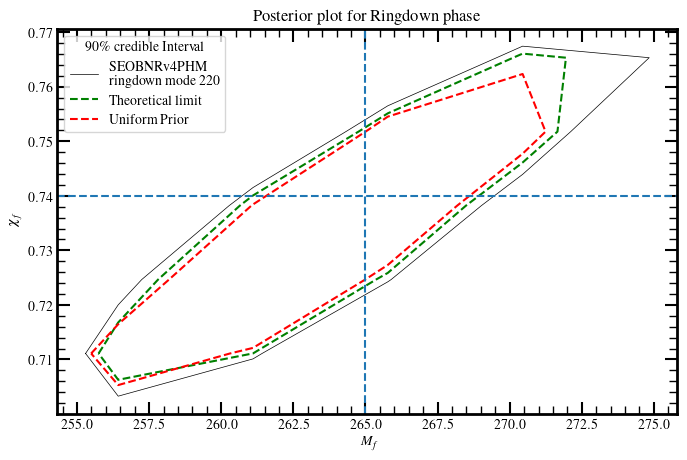

In [11]:
plotinspiral(modes = ["220"], failperc = 10, Ef = Ef)
plotringdown(modes = ["220"], failperc = 10, Ef = Ef)

# Final Entropy

For n:  2.0
For Ringdown mode  220
Empty DataFrame
Columns: [Row #, Fail %]
Index: []
For n:  1.0
For Ringdown mode  220
     Row #      Fail %
0        0  100.000000
1        1  100.000000
2        2  100.000000
3        3  100.000000
4        4  100.000000
..     ...         ...
346    450   81.706486
347    466   88.084145
348  19703   86.246129
349  19749   95.039914
350  19793   85.937899

[351 rows x 2 columns]
For n:  0.5
For Ringdown mode  220
      Row #      Fail %
0         0  100.000000
1         1  100.000000
2         2  100.000000
3         3  100.000000
4         4  100.000000
...     ...         ...
2825  19817   99.855118
2826  19818   99.998580
2827  19819   99.828130
2828  19820   99.893469
2829  19821  100.000000

[2830 rows x 2 columns]


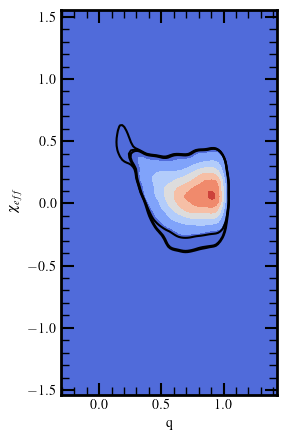

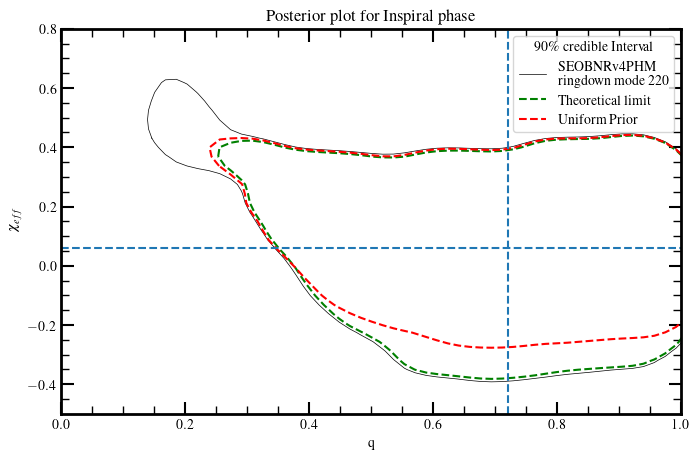

In [12]:
fp = inference.io.loadfile("KERR-220-07MS.hdf", "r")
samples = fp.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
final_mass = samples["final_mass"]
final_spin = samples["final_spin"]
Ef = (final_mass**2) * (
    1 + np.sqrt(1 - np.abs(final_spin) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
Ef = Ef.reshape(
    1, Ef.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
plotinspiral(modes = ["220"], failperc = 80, Ef = Ef)

For n:  2.0
For Ringdown mode  220_221
Empty DataFrame
Columns: [Row #, Fail %]
Index: []
For n:  1.0
For Ringdown mode  220_221
     Row #      Fail %
0        0  100.000000
1        1  100.000000
2        2   99.998801
3        3   99.977226
4        4   99.949657
..     ...         ...
552    599   83.370092
553    610   82.004842
554    612   85.380208
555    617   81.067507
556    646   82.624539

[557 rows x 2 columns]
For n:  0.5
For Ringdown mode  220_221
     Row #      Fail %
0        0  100.000000
1        1  100.000000
2        2   99.998801
3        3   99.977226
4        4   99.949657
..     ...         ...
871  19817   87.124227
872  19818   98.770197
873  19819   86.200077
874  19820   90.271851
875  19821   99.332358

[876 rows x 2 columns]


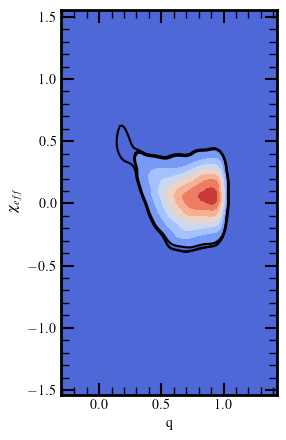

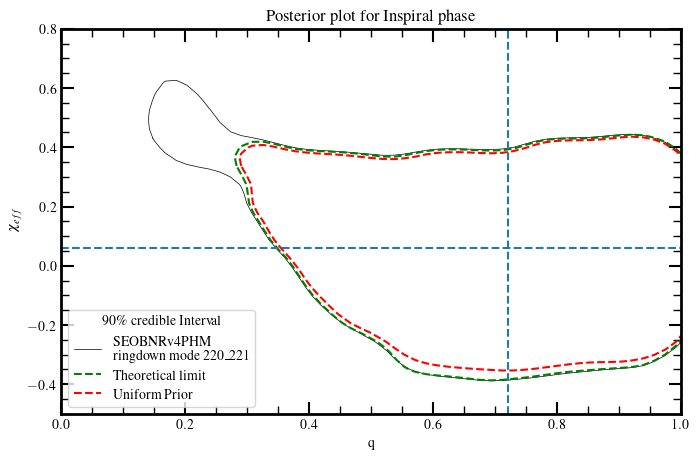

In [13]:
fp = inference.io.loadfile("KERR-220_221-07MS.hdf", "r")
samples = fp.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
final_mass = samples["final_mass"]
final_spin = samples["final_spin"]
Ef = (final_mass**2) * (
    1 + np.sqrt(1 - np.abs(final_spin) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now
Ef = Ef.reshape(
    1, Ef.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
plotinspiral(modes = ["220_221"], failperc = 80, Ef = Ef)

In [14]:
def brahmacolumns(rho, limit, modes):
    # mode should be string 220 or 220_221
    """rho = Percentage of fail to be dropped off; limit = Theoretical limit, uniform prior, astrophysical prior"""
    if limit > 1:  # so that original samples remain same after applying np.delete to delete rows/columns
        # rows = [] # nothing will get deleted
        columns = []
        failcolumn = []
        return columns, failcolumn
    columns = np.array([])
    failcolumn =  np.array([])
    if modes == "220":
        for j in range(Ef220.shape[1]):     
            IBBH = (1 / 3) * (Ef220[0, j] - E1 - E2) / (E1 + E2)  # columns
            for i in range(IBBH.shape[1]):
                if np.sum(IBBH[:, i] > limit) >= 1 or np.sum(IBBH[:, i] < 0) >= 1:
                    fail = 100 * (np.sum(IBBH[:, i] > limit) + np.sum(IBBH[:, i] < 0)) / IBBH.shape[0]
                    # print("Column number number ", i, " percentage of Fail values ", fail)
                    if fail >= rho:
                        columns = np.append(columns, int(j))
                        failcolumn = np.append(failcolumn,fail)
                        # IBBH_new = np.delete(IBBH, i, axis=1)

                        
    elif modes == "220_221":
        for j in range(Ef220221.shape[1]):     
            IBBH = (1 / 3) * (Ef220221[0, j] - E1 - E2) / (E1 + E2)  # columns
            for i in range(IBBH.shape[1]):
                if np.sum(IBBH[:, i] > limit) >= 1 or np.sum(IBBH[:, i] < 0) >= 1:
                    fail = 100 * (np.sum(IBBH[:, i] > limit) + np.sum(IBBH[:, i] < 0)) / IBBH.shape[0]
                    # print("Column number number ", i, " percentage of Fail values ", fail)
                    if fail >= rho:
                        columns = np.append(columns, int(j))
                        failcolumn = np.append(failcolumn,fail)

                
    # print("Minimum value in IBBH is ", np.min(IBBH))
    # print("Maximum value in IBBH is ", np.max(IBBH))
    # print("Shape of IBBH is ", IBBH.shape)
    # print("Sum of values > 1 of IBBH ", np.sum(IBBH > limit))
    # print("Sum of values < 0 of IBBH ", np.sum(IBBH < 0))
    # print(
    #     "Percentage of IBBH to be removed ",
    #     ((np.sum(IBBH > limit) + np.sum(IBBH < 0)) / (IBBH.shape[0] * IBBH.shape[1])) * 100,
    # )

    columns = columns.astype(np.int64)  # represents columns numbers to be deleted
    # print("Column numbers ", columns)

    return columns, failcolumn


In [39]:
posterior_samples_file = "GW190521_posterior_samples.h5"

samples_file = h5py.File(posterior_samples_file, "r")
seob = samples_file["SEOBNRv4PHM"]["posterior_samples"]
samples_dict = dict(SEOB=seob)


n = np.array(
    [2, 1, 0.5]
)  # Theoretical limit, uniform prior, astrophysical prior, Anything greater than 1 means original samples i.r. rows = []
# Removing rows which fail the BRAHMA ramework test
# modes = ["220_221", "220"]
def plotringdown(modes):
    for limit in n:
        print("For n: ", limit)
        for mode in modes:
            print("For Ringdown mode ", mode)
            # rows = brahmarows(rho=10, limit=limit, modes=mode)  # row and columns numbers to be deleted
            columns, fail = brahmacolumns(rho=10, limit=limit, modes=mode)  # row and columns numbers to be deleted
            table = list(zip(columns,fail))
            df = pd.DataFrame(data = table, columns = ["Column #", "Fail %"])
            print(df)
            if mode == "220":
                samples = fp220.read_samples(fp220["samples"].keys(), temps=0)

            if mode == "220_221":
                samples = fp220221.read_samples(fp220221["samples"].keys(), temps=0)
            # print(rows)
            # chi_eff = np.delete(samples_dict["SEOB"]["chi_eff"], rows, axis=0)
            # q = np.delete(samples_dict["SEOB"]["mass_ratio"], rows, axis=0)



            final_spin = np.delete(samples["final_spin"], columns, axis=0)
            final_mass = np.delete(samples["final_mass"], columns, axis=0)
            loglikelihood = np.delete(samples["loglikelihood"], columns, axis=0)
            x = final_mass
            y = final_spin

            # Extract x and y
            # x = q
            # y = chi_eff

            if limit > 1 and mode == "220_221":  #
                deltaX = (max(x) - min(x)) / 2
                deltaY = (max(y) - min(y)) / 2
                xmin = min(x) - deltaX
                xmax = max(x) + deltaX
                ymin = min(y) - deltaY
                ymax = max(y) + deltaY
                # print(ymin, ymax)
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

                fig = plt.figure(figsize=(8, 5))
                ax = fig.gca()
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            if values.shape[1] == 0:
                continue
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            cfset1 = ax.contourf(xx, yy, f, cmap="coolwarm")

            percentiles = np.array([90.0])
            percentiles = 100.0 - np.array(percentiles)
            percentiles.sort()

            draw = kernel.resample
            resamps = kernel(draw(int(100**2)))
            s = np.percentile(resamps, percentiles)

            ax.imshow(np.rot90(f), cmap="coolwarm", extent=[xmin, xmax, ymin, ymax])

            cset = ax.contour(xx, yy, f, s, colors="k")
            if limit > 1 and mode == "220_221":  #
                plt.figure(figsize=(8, 5))
            text = ["SEOBNRv4PHM", "Theoretical limit", "Uniform Prior", "Astrophysical Prior"]
            colors = ["k", "g", "r"]
            for j in range(len(cset.allsegs)):
                for ii, seg in enumerate(cset.allsegs[j]):
                    if ii == 0:
                        if limit > 1:
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "-",
                                lw = 1.5,
                                zorder = 1,
                                color=colors[np.where(n == limit)[0][0]],
                                label=text[np.where(n == limit)[0][0]] + "\n ringdown mode " + str(mode),
                            )
                            
                        elif mode == "220_221":
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "-",
                                color='g', 
                                label=text[np.where(n == limit)[0][0]],
                            )
                        elif mode == "220":
                            plt.plot(
                                seg[:, 0],
                                seg[:, 1],
                                "--",
                                color='r',
                                label=text[np.where(n == limit)[0][0]],
                            )
                    else:
                        plt.plot(seg[:, 0], seg[:, 1], "--", color=colors[np.where(n == limit)[0][0]])  # ax.set_xlabel("q")
    # ax.set_xlabel("q")
    # ax.set_ylabel("$\chi_{eff}$")
    # plt.title("Posterior plot for Inspiral phase ")
    # plt.ylim(-0.5, 0.8)
    # plt.xlim(0,1)
    # plt.xlabel("q")
    # plt.ylabel("$\chi_{eff}$")
    # plt.legend(title='90$\%$ credible Interval')
    # # plt.xlim(245,400)
    # plt.axvline(0.72,linestyle = '--')
    # plt.axhline(0.7,linestyle = '--')
    # plt.savefig("Inspiral220_221-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")



    ax.set_xlabel("$M_f$")
    ax.set_ylabel("$\chi_{f}$")
    plt.title("Posterior plot for Ringdown phase")

    plt.xlabel("$M_f$")
    plt.ylabel("$\chi_{f}$")
    plt.legend(title='90$\%$ credible Interval')
    plt.xlim(245,400)
    plt.axvline(254.31,linestyle = '--')
    plt.axhline(0.72,linestyle = '--')
    plt.savefig(f"Ringdown{modes}-07MS_SEOBNRv4PHM.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [40]:
fp220221 = inference.io.loadfile("KERR-220_221-07MS.hdf", "r")
fp220 = inference.io.loadfile("KERR-220-07MS.hdf", "r")
samples220 = fp220.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)
samples220221 = fp220221.read_samples(["final_mass", "final_spin", "loglikelihood"], temps=0)


loglikelihood220 = samples220["loglikelihood"]
final_mass220 = samples220["final_mass"]
final_spin220 = samples220["final_spin"]

Ef220 = (final_mass220**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now

Ef220 = Ef220.reshape(
    1, Ef220.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
E1 = E1.reshape(E1.shape[0], 1)
E2 = E2.reshape(E2.shape[0], 1)


loglikelihood220221 = samples220221["loglikelihood"]
final_mass220221 = samples220221["final_mass"]
final_spin220221 = samples220221["final_spin"]

Ef220221 = (final_mass220221**2) * (
    1 + np.sqrt(1 - np.abs(final_spin220221) ** 2)
)  # Initial Entropy of BH1 # ignoring 2piG/ch = ((4*np.pi**2 * 10**15)/(3)) for now

Ef220221 = Ef220221.reshape(
    1, Ef220221.shape[0]
)  # changed the order for making IBBH which is m*n matrix....so using np vectorization here by changing orders and adding E1+E2
print(E1.shape, E2.shape, Ef220.shape)
print(E1.shape, E2.shape, Ef220221.shape)


(19822, 1) (19822, 1) (1, 70402)
(19822, 1) (19822, 1) (1, 83428)


For n:  2.0
For Ringdown mode  220
Empty DataFrame
Columns: [Column #, Fail %]
Index: []
For Ringdown mode  220_221
Empty DataFrame
Columns: [Column #, Fail %]
Index: []
For n:  1.0
For Ringdown mode  220
Empty DataFrame
Columns: [Column #, Fail %]
Index: []
For Ringdown mode  220_221
    Column #     Fail %
0       2055  13.051155
1       2381  11.446877
2       2635  11.325800
3       3573  12.612249
4       3965  10.614469
..       ...        ...
81     78759  37.211179
82     79186  12.052265
83     79473  10.730501
84     81620  15.810715
85     82784  11.113914

[86 rows x 2 columns]
For n:  0.5
For Ringdown mode  220
       Column #     Fail %
0             0  15.053980
1             1  19.997982
2             2  37.407931
3             3  10.251236
4             4  19.932398
...         ...        ...
66112     70397  24.609020
66113     70398  45.182121
66114     70399  21.491272
66115     70400  19.150439
66116     70401  37.619816

[66117 rows x 2 columns]
For Ringdown mode 

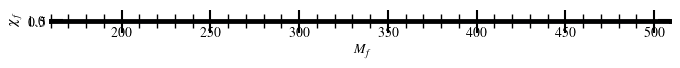

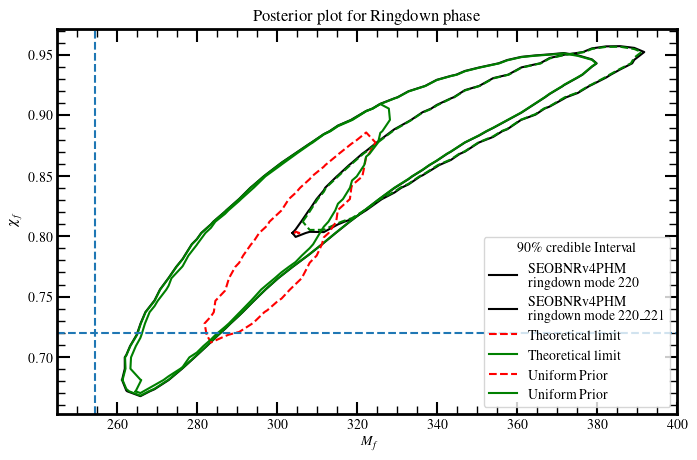

In [34]:
plotringdown(["220","220_221"])

For n:  2.0
For Ringdown mode  220
Empty DataFrame
Columns: [Column #, Fail %]
Index: []
For n:  1.0
For Ringdown mode  220
Empty DataFrame
Columns: [Column #, Fail %]
Index: []
For n:  0.5
For Ringdown mode  220
       Column #     Fail %
0             0  15.053980
1             1  19.997982
2             2  37.407931
3             3  10.251236
4             4  19.932398
...         ...        ...
66112     70397  24.609020
66113     70398  45.182121
66114     70399  21.491272
66115     70400  19.150439
66116     70401  37.619816

[66117 rows x 2 columns]


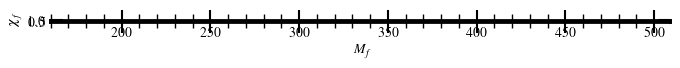

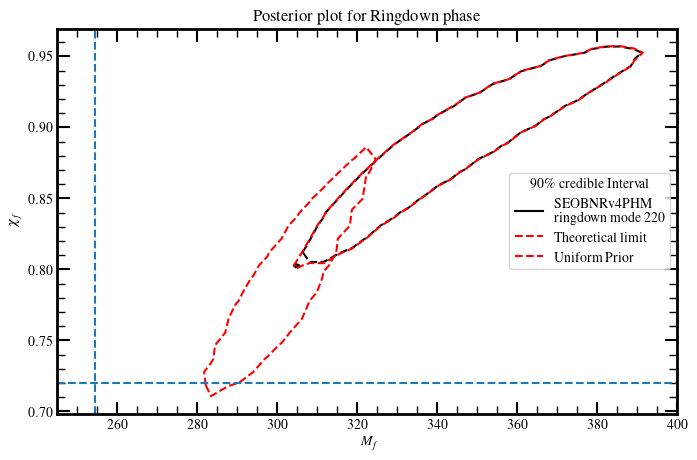

In [35]:
plotringdown(["220"])

In [1]:
plotringdown(["220_221"])

NameError: name 'plotringdown' is not defined

In [ ]:
# why regions in ringdown go out of original??/